In [1]:
# facilitate imports from project root
import sys
sys.path.append("..")

In [2]:
from chase_rank.match import match_track

In [3]:
import collections
from copy import copy

import gpxpy
import overpy
import pyproj
import contextily as cx
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point
from shapely.ops import transform
from routingpy import OSRM, Valhalla, convert, utils

from chase_rank.way_categorizer import categorize_way

In [4]:
TEST_TRACK_PATH = "../data/routes/test_track.gpx"

BASEMAP_SOURCE = cx.providers.CartoDB.Positron

VALHALLA_CLIENT = Valhalla(base_url="http://127.0.0.1:8002")
OVERPASS_API = overpy.Overpass()

---
# Datei Laden

In [5]:
with open(TEST_TRACK_PATH) as file_pointer:
    gpx_content = gpxpy.parse(file_pointer)

gpx_data = []
gpx_geometry = []
for point in gpx_content.tracks[0].segments[0].points:
    gpx_geometry.append(Point(point.longitude, point.latitude))
    gpx_data.append({
        # clear tzinfo until it can be handled for the match query
        "time": point.time.replace(tzinfo=None),
        "elev": point.elevation,
        "longitude": point.longitude,
        "latitude": point.latitude
    })

gpx_frame = gpd.GeoDataFrame(
    gpx_data, geometry=gpx_geometry, crs="EPSG:4326").to_crs("EPSG:3857")
# search for splits in the trace bigger than 1s and label consecutive sections
gpx_frame["section"] = (gpx_frame["time"].diff() != pd.Timedelta("1 second")).cumsum()

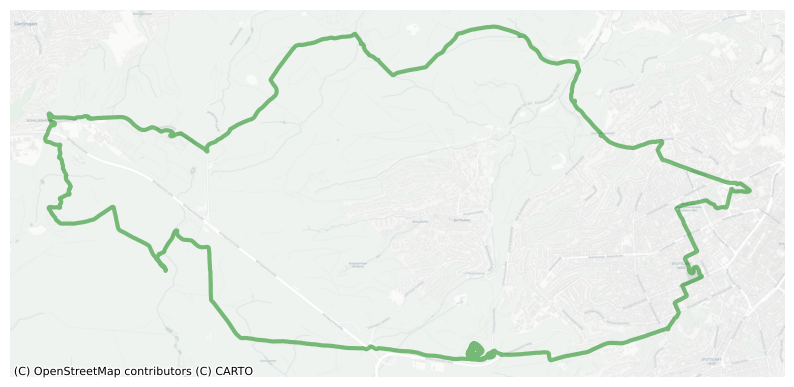

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
gpd.GeoDataFrame(geometry=[LineString(gpx_frame["geometry"])]).plot(
    ax=ax, color="green", linewidth=3, alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=BASEMAP_SOURCE)
_ = ax.axis("off")

---
# Matching

In [7]:
trace_df, edges_df = match_track(gpx_frame)

132 


 1
locations 109
{'units': 'kilometers', 'osm_changeset': 10170092172, 'shape': 'c|g`|AwtfnPpBkAaS}y@qBtBa@}CaCue@OmCRuDiBgr@}Dqz@Qo@_@gA_@oAa@q@]m@wA}BmB_HtAaIz@KGoACi@wAuVx@}BhHiSnQux@fC{AtWaOeK_m@[mBkAwGjAmMc@_GS{C', 'confidence_score': 1.0, 'raw_score': 134.516, 'admins': [{'country_text': 'None', 'state_text': 'None'}], 'edges': [{'truck_route': False, 'density': 11, 'sac_scale': 0, 'shoulder': False, 'sidewalk': 'none', 'bicycle_network': 0, 'cycle_lane': 'none', 'lane_count': 1, 'max_downward_grade': -500, 'max_upward_grade': -500, 'weighted_grade': 0.0, 'way_id': 630532835, 'id': 7055429707426, 'travel_mode': 'bicycle', 'bicycle_type': 'cross', 'surface': 'paved_smooth', 'drive_on_right': False, 'internal_intersection': False, 'roundabout': False, 'bridge': False, 'tunnel': False, 'unpaved': False, 'toll': False, 'use': 'service_road', 'traversability': 'both', 'end_shape_index': 1, 'begin_shape_index': 0, 'end_heading': 156, 'begin_heading': 156, 'road_class': 'service_

C:\Users\4rkla\PycharmProjects\chase-rank\venv\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


In [49]:
map_ = gpx_frame[["geometry", "section"]].explore(
    name="gpx", color="green", style_kwds={"opacity": 0.5})
map_ = trace_df[trace_df["geometry"].notnull()].explore(
    m=map_, name="trace", color="blue", style_kwds={"opacity": 0.1})
map_ = edges_df.explore(
    m=map_, name="edges", color="red", style_kwds={"opacity": 0.5})

map_

In [9]:
4840 / 5648

0.8569405099150141

In [10]:
trace_df.apply(
    lambda row: edges_df.iloc[row["edge_index"]]
    if isinstance(row["edge_index"], int) else None, axis=1)[
    ["length", "speed", "use", "unpaved", "surface", "travel_mode", "osm_way_id",
     "geometry"]
]

length  speed           use unpaved       surface travel_mode  \
0      0.007   20.0  service_road   False  paved_smooth     bicycle   
1      0.007   20.0  service_road   False  paved_smooth     bicycle   
2      0.007   20.0  service_road   False  paved_smooth     bicycle   
3      0.007   20.0  service_road   False  paved_smooth     bicycle   
4      0.078   20.0          road   False  paved_smooth     bicycle   
...      ...    ...           ...     ...           ...         ...   
5643   0.002   20.0  service_road   False  paved_smooth     bicycle   
5644   0.002   20.0  service_road   False  paved_smooth     bicycle   
5645   0.002   20.0  service_road   False  paved_smooth     bicycle   
5646   0.002   20.0  service_road   False  paved_smooth     bicycle   
5647     NaN    NaN          None    None          None        None   

       osm_way_id                                           geometry  
0     630532835.0  LINESTRING (1019974.631 6237568.495, 1019978.8...  
1     630532835.0  LINESTRING (1019974.631 6237568.495, 1019978.8...  
2     630532835.0  LINESTRING (1019974.631 6237568.495, 1019978.8...  
3     630532835.0  LINESTRING (1019974.631 6237568.495, 1019978.8...  
4     288879691.0  LINESTRING (1019978.861 6237558.866, 1020083.8...  
...           ...                                                ...  
5643  266499727.0  LINESTRING (1019974.631 6237568.495, 1019973.2...  
5644  266499727.0  LINESTRING (1019974.631 6237568.495, 1019973.2...  
5645  266499727.0  LINESTRING (1019974.631 6237568.495, 1019973.2...  
5646  266499727.0  LINESTRING (1019974.631 6237568.495, 1019973.2...  
5647          NaN                                               None  

[5648 rows x 8 columns]

In [48]:
edges_df["use"].unique()

array(['service_road', 'road', 'footway', 'path', 'track',
       'parking_aisle'], dtype=object)

In [11]:
trace_df[trace_df["geometry"].notnull() & trace_df["edge_index"].notnull()]

index       lon        lat          type edge_index  \
0         0  9.162588  48.779730       matched          0   
1         1  9.162588  48.779730  interpolated          0   
2         2  9.162588  48.779730  interpolated          0   
3         3  9.162588  48.779730  interpolated          0   
4         4  9.162741  48.779712       matched          1   
...     ...       ...        ...           ...        ...   
5642      5  9.162563  48.779653  interpolated        453   
5643      6  9.162588  48.779730       matched        455   
5644      7  9.162576  48.779746  interpolated        455   
5645      8  9.162575  48.779747  interpolated        455   
5646      9  9.162575  48.779747       matched        455   

      distance_along_edge  distance_from_trace_point  \
0                0.000000                   7.230379   
1                0.000000                   6.874434   
2                0.000000                   6.920278   
3                0.000000                   8.325209   
4                0.122302                  12.910536   
...                   ...                        ...   
5642             0.553484                   8.520126   
5643             1.000000                   4.591432   
5644             0.087702                   3.727745   
5645             0.094551                   3.326923   
5646             0.094551                   3.260199   

                             geometry  
0     POINT (1019974.631 6237568.495)  
1     POINT (1019974.631 6237568.495)  
2     POINT (1019974.631 6237568.495)  
3     POINT (1019974.631 6237568.495)  
4     POINT (1019991.662 6237565.455)  
...                               ...  
5642  POINT (1019971.848 6237555.488)  
5643  POINT (1019974.631 6237568.495)  
5644  POINT (1019973.295 6237571.198)  
5645  POINT (1019973.183 6237571.367)  
5646  POINT (1019973.183 6237571.367)  

[5345 rows x 8 columns]

In [12]:
edges_df

index  length  speed     road_class traversability           use  \
0        0   0.007     20  service_other           both  service_road   
1        1   0.078     20    residential           both          road   
2        2   0.008     20  service_other           both       footway   
3        3   0.052     20  service_other           both          path   
4        4   0.005     20  service_other           both          path   
..     ...     ...    ...            ...            ...           ...   
451      8   0.112     20    residential           both          road   
452      9   0.004     20    residential           both          road   
453      0   0.011     20    residential           both          road   
454      1   0.007     20  service_other           both  service_road   
455      2   0.002     20  service_other           both  service_road   

     unpaved  tunnel  bridge  roundabout  ...       surface travel_mode  \
0      False   False   False       False  ...  paved_smooth     bicycle   
1      False   False   False       False  ...  paved_smooth     bicycle   
2      False   False   False       False  ...  paved_smooth     bicycle   
3      False   False   False       False  ...         paved     bicycle   
4      False   False   False       False  ...         paved     bicycle   
..       ...     ...     ...         ...  ...           ...         ...   
451    False   False   False       False  ...  paved_smooth     bicycle   
452    False   False   False       False  ...  paved_smooth     bicycle   
453    False   False   False       False  ...  paved_smooth     bicycle   
454    False   False   False       False  ...  paved_smooth     bicycle   
455    False   False   False       False  ...  paved_smooth     bicycle   

     osm_way_id  max_upward_grade  max_downward_grade  mean_elevation  \
0     630532835              -500                -500            None   
1     288879691              -500                -500            None   
2      23279255              -500                -500            None   
3      23279257              -500                -500            None   
4      23279257              -500                -500            None   
..          ...               ...                 ...             ...   
451   343982745              -500                -500            None   
452  1034750260              -500                -500            None   
453   288879691              -500                -500            None   
454   630532835              -500                -500            None   
455   266499727              -500                -500            None   

    sac_scale  speed_limit indoor  \
0           0          NaN   None   
1           0         30.0   None   
2           0          NaN   None   
3           0          NaN   None   
4           0          NaN   None   
..        ...          ...    ...   
451         0           30   None   
452         0           30   None   
453         0         30.0   None   
454         0          NaN   None   
455         0          NaN   None   

                                              geometry  
0    LINESTRING (1019974.631 6237568.495, 1019978.8...  
1    LINESTRING (1019978.861 6237558.866, 1020083.8...  
2    LINESTRING (1020083.835 6237613.094, 1020077.2...  
3    LINESTRING (1020077.267 6237622.723, 1020086.0...  
4    LINESTRING (1020154.968 6237636.576, 1020162.8...  
..                                                 ...  
451  LINESTRING (1020036.635 6237398.212, 1020029.8...  
452  LINESTRING (1019963.165 6237551.433, 1019960.0...  
453  LINESTRING (1019963.165 6237551.433, 1019978.8...  
454  LINESTRING (1019978.861 6237558.866, 1019974.6...  
455  LINESTRING (1019974.631 6237568.495, 1019973.2...  

[456 rows x 21 columns]

In [17]:
map_ = gpx_frame[["geometry", "section"]][
    trace_df["geometry"].isnull()
].explore(name="gpx", color="green", style_kwds={"opacity": 0.5})
map_ = gpx_frame[["geometry", "section"]][
    trace_df["edge_index"].isnull()
].explore(m=map_, name="gpx", color="red", style_kwds={"opacity": 0.5, "fill": False})

map_

In [45]:
locations = list(gpx_frame[["geometry", "section"]][
    trace_df["geometry"].isnull()
].groupby(by="section"))[0][1]["geometry"].values.tolist()
locations

In [14]:
locations = gpx_frame[["longitude", "latitude"]].values.tolist()
coords = convert.delimit_list(
    [convert.delimit_list([convert.format_float(f) for f in pair]) for pair in locations], ";"
)
timestamps = ";".join(
    ((gpx_frame["time"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")).astype(str).values.tolist())